# Lab 06: Gene Expression

---
author: Alejandra Arias
date: October 18, 2024
embed-resources: true
---

## Introduction

For this report, we will be using gene expression data to develop a model that will predict the cancer type of a tissue sample.

### Background
[Cancer detection](https://en.wikipedia.org/wiki/Cancer_screening) is a critical step in the treatment of the disease. Early detection can lead to more effective treatments and better outcomes for patients. Gene expression data can be used to develop models that can predict the type of cancer based on the expression levels of certain genes. A researched possibility is the use of genetic information to push detection earlier and more accurately. One example is the [BRCA mutation](https://en.wikipedia.org/wiki/BRCA_mutation) which is associated with an increased risk of breast and ovarian cancer.

### Goal of this Report
As a data scientist working for a biotech company, we have been tasked with developing a "universal" cancer deteciton model that can predict the type of cancer based on gene expression data. We will use a dataset collected via [next-generation sequencing](https://en.wikipedia.org/wiki/Massive_parallel_sequencing) that contains gene expression data for different types of cancer and develop a machine learning model that can predict the cancer type based on the gene expression levels. The end goal is not a perfect solution but rather a model that can be used as a starting point for further research and development.

### Source
The original source of the data is the [Cancer Genome Atlas Pan-Cancer Analysis Project](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga). The data was accessed via [synapse.org](https://www.synapse.org/#!Synapse:syn300013). The specific data for this report was collected and modified based on the submission to the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq).

## Methods

In [53]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso

### Data

In [54]:
# load data
cancer_train = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-train.parquet",
)
cancer_test = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-test.parquet",
)
cancer_train

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
0,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
1,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
2,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
3,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
4,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
124,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
125,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
126,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


## Data Dictionary

The data in this report is gene expression and clinical outcome. The data is given to us for this report.


Each observation in the train, test, and production data contains clinical information and gene expression data for a tissue sample. 

### Response
**`cancer`**

- `[object64]` quality of the wine rated on a scale from 3 to 10, with 3 being the lowest quality and 10 being the highest quality
- - `BRCA`: Breast Invasive Carcinoma
- - `COAD`: Colon Adenocarcinoma
- - `KIRC`: Kidney Renal Clear Cell Carcinoma
- - `LUAD`: Lung Adenocarcinoma
- - `PRAD`: Prostate Adenocarcinoma

### Features
**`gene_`**

- `[float64]` gene expression quantification measured by an Illumina HiSeq platform.
    

In [55]:
# summary statistics
cancer_train.shape
# to get the shape
cancer_train


,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
0,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
1,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
2,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
3,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
4,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
124,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
125,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
126,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


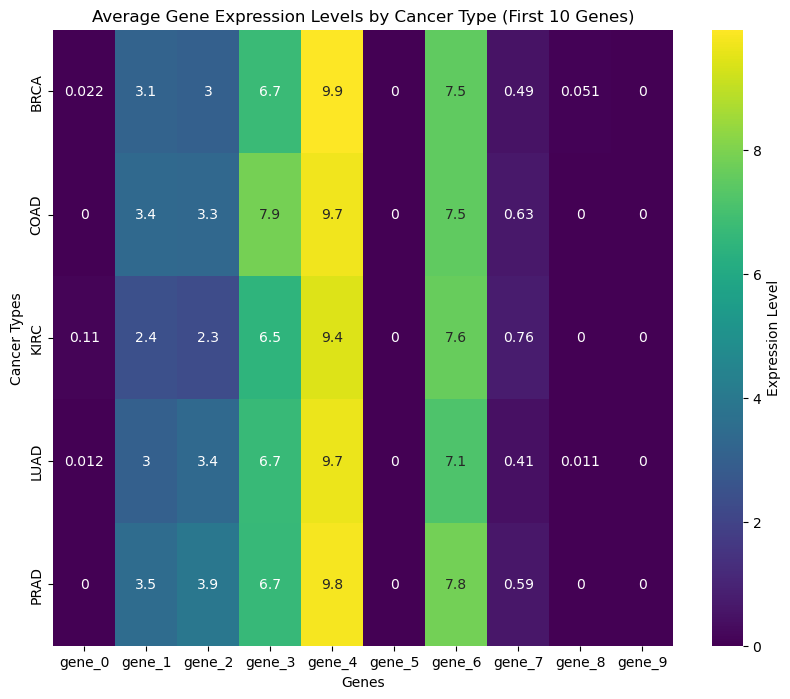

In [56]:
# visualizations
cancer_grouped = cancer_train.groupby('cancer').mean().iloc[:, :10]  # Select only the first 10 genes because theres too much data

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cancer_grouped, annot=True, cmap="viridis", cbar_kws={'label': 'Expression Level'})
plt.title("Average Gene Expression Levels by Cancer Type (First 10 Genes)")
plt.xlabel("Genes")
plt.ylabel("Cancer Types")
plt.show()


The heatmap shows the correlation between the gene expression levels of the different genes in the dataset. The correlation coefficient ranges from 0 to 1, where 1 indicates a strong positive correlation and 0 indicates no correlation. For the sake of time and limited space in this report, the visualization shows the first 10 genes in the dataset. We see that gene_4 and gene_6 have a strong correlation with all cancer types whereas gene_5 and gene_9 have no correlation with any cancer type.

### Models

In [57]:
# create X and y for train
X_train = cancer_train.drop(columns=["cancer"])
y_train = cancer_train["cancer"]

# create X and y for test
X_test = cancer_test.drop(columns=["cancer"])
y_test = cancer_test["cancer"]

In [58]:
numeric_features = X_train.select_dtypes(include=["float64", "int64"]).columns
categorical_features = ["cancer"]

In [59]:
# process data for ML
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)


# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("Classifier", LogisticRegression()),
    ]
)

In [60]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6',
       'gene_7', 'gene_8', 'gene_9',
       ...
       'gene_1990', 'gene_1991', 'gene_1992', 'gene_1993', 'gene_1994',
       'gene_1995', 'gene_1996', 'gene_1997', 'gene_1998', 'gene_1999'],
      dtype='object', length=2000))])),
                ('Classifier', LogisticRegression())])

In [61]:
param_grid = [
    {
        "Classifier": [DummyClassifier()],
    },
    {
        "Classifier": [RandomForestClassifier()],
        "Classifier__max_features": [1, 3, 10],
        "Classifier__n_estimators": [25, 100],
        "Classifier__max_samples": [10, None],
    },
    {
        "Classifier": [LogisticRegression()],
        "Classifier__penalty": ["l1", "l2"],
        "Classifier__solver": ["liblinear"],
        "Classifier__C": 1 / (10.0 ** np.arange(-4, 3))
    },
]

In [62]:
mod = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
mod.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6',
       'gene_7', 'gene_8', 'gene_9',
       ...
       'gene_1990', 'gene_1991', 'gene_1992', 'gene_1993', 'gene_1994',
       'gene_1995', 'gene_1996', 'gene_1997', 'gene_199...
                         {'Classifier': [RandomForestClassifier()],
                          'Classifier__max_features': [1, 3, 10],
                          'Classifier__max_samples': [10, None],
                          'Classifier__n_estimators': [25, 100]},
                         {'Classifier': [LogisticRegression()],
                          'Classifier__C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02]),
                          'Classifier__penalty': ['l1', 'l2'],
                          'Classifier__solver': ['liblinear']}],
             scoring='accuracy', verbose=1)

In [63]:
print(f"Best parameters: {mod.best_params_}")
print(f"Best cross-validation accuracy: {mod.best_score_}")

Best parameters: {'Classifier': LogisticRegression(), 'Classifier__C': 10000.0, 'Classifier__penalty': 'l1', 'Classifier__solver': 'liblinear'}
Best cross-validation accuracy: 1.0


To develop this model, a GridSearchCV was used to find the best hyperparameters for the model. The model used was a Dummy Classifier, Random Forest Classifier, and a Logistic Regression Classifier. The model with the best performance was selected as the final model which was Logistic Regression. 

For the first dictionary, the model used a Dummy Classifier with no hyperparameters so only the classifier will be evaluated. This classifier will be used as a baseline to compare the other models as it doesnt learn patterns but makes predictions based on simple rules. The second model used a Random Forest Classifier with hyperparameters of max_depth, n_estimators, and max_samples. The third model used a Logistic Regression Classifier with hyperparameters of C, solver, and penalty. The C classifier is the inverse of regularization strength, the solver is the algorithm to use in the optimization problem, and the penalty is the norm used in the penalization. 

Before these parameters were used, the data was split into a training and testing set. The training set was used to train the model and the testing set was used to evaluate the model. We used a pipeline to preprocess the data and then fit the model. The model was then evaluated using the testing set. We also used a SimpleImputer to fill in missing values and a StandardScaler to scale the data.

## Results

In [64]:
y_pred = mod.predict(X_test)
print(f"Test Accuracy: {mod.score(X_test, y_test):.2f}")

Test Accuracy: 1.00


,mean_test_score,param_Classifier,param_Classifier__max_features,param_Classifier__n_estimators,param_Classifier__penalty,param_Classifier__C
0,0.367077,DummyClassifier(),NaN,NaN,NaN,NaN
1,0.688000,RandomForestClassifier(),1,25,NaN,NaN
2,0.710769,RandomForestClassifier(),1,100,NaN,NaN
3,0.929846,RandomForestClassifier(),1,25,NaN,NaN
4,0.937538,RandomForestClassifier(),1,100,NaN,NaN
5,0.710462,RandomForestClassifier(),3,25,NaN,NaN
6,0.812308,RandomForestClassifier(),3,100,NaN,NaN
7,0.937538,RandomForestClassifier(),3,25,NaN,NaN
8,0.960923,RandomForestClassifier(),3,100,NaN,NaN
9,0.796923,RandomForestClassifier(),10,25,NaN,NaN


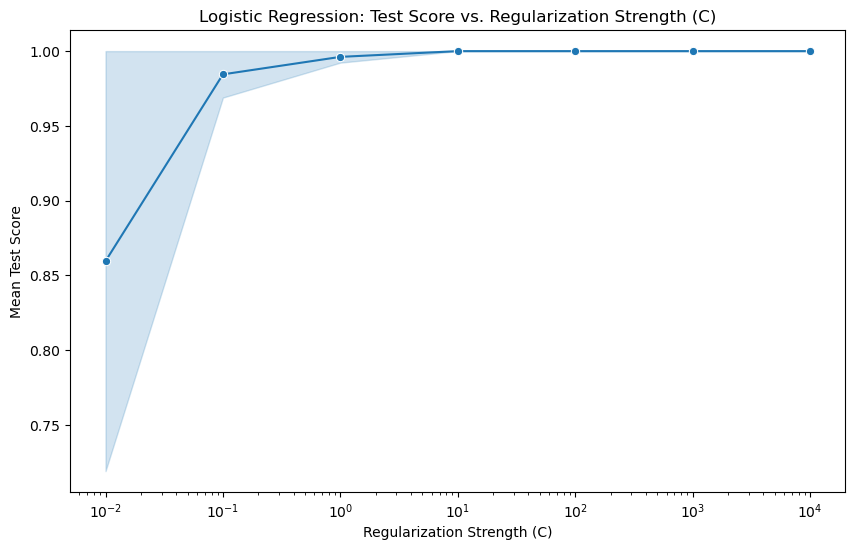

In [65]:
results_df = pd.DataFrame(mod.cv_results_)
display(results_df[['mean_test_score', 'param_Classifier', 'param_Classifier__max_features', 
                    'param_Classifier__n_estimators', 'param_Classifier__penalty', 'param_Classifier__C']])

log_reg_results = results_df[results_df['param_Classifier'].apply(lambda x: x.__class__.__name__) == "LogisticRegression"]
plt.figure(figsize=(10, 6))
sns.lineplot(data=log_reg_results, x="param_Classifier__C", y="mean_test_score", marker='o')
plt.xscale('log')
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Mean Test Score")
plt.title("Logistic Regression: Test Score vs. Regularization Strength (C)")
plt.show()

The results of the model are shown in the table above. The model with the best performance was the Logistic Regression Classifier with an accuracy of 1. The Dummy Classifier had an accuracy of 0.36 and the Random Forest Classifier had an accuracy of 0.98. The Logistic Regression Classifier had the highest accuracy and was selected as the final model. As the C values increase, so does the model performance. At C=0, the model reaches peak performance which suggests that beyond a certain point, increasing the C value does not improve the model performance so it is likely the model reached its optimal performance at C=0.

## Discussion

To test our data in a "real-world application", we will create synethic data from the dataframe.

In [66]:
#to avoid scrollable output
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
# grouping the data by cancer type
grouped_stats = cancer_train.groupby("cancer").agg(['mean', 'std'])
grouped_stats.columns = ['_'.join(col) for col in grouped_stats.columns]
def generate_synthetic_data(cancer_type, num_samples):
    stats = grouped_stats.loc[cancer_type]
    synthetic_data = pd.DataFrame()
    for gene in range(2000):  # assuming 10 genes, adjust if more
        gene_mean = stats[f'gene_{gene}_mean']
        gene_std = stats[f'gene_{gene}_std']
        synthetic_data[f'gene_{gene}'] = np.random.normal(gene_mean, gene_std, num_samples)
    synthetic_data['cancer'] = cancer_type
    return synthetic_data

synthetic_samples = pd.concat([generate_synthetic_data(cancer, 100) for cancer in cancer_train['cancer'].unique()])


In [67]:
synthetic_X = synthetic_samples.drop("cancer", axis=1)
synthetic_y = synthetic_samples["cancer"]
best_model = mod.best_estimator_
synthetic_pred = best_model.predict(synthetic_X)
print(f"Synthetic Test Accuracy: {mod.score(synthetic_X, synthetic_y):.2f}")


Synthetic Test Accuracy: 1.00


Given that our test accuracy was 1, synthetic data was created based on the dataframe from earlier in the report. The synthetic data was created using the same columns as the original dataframe to predict the cancer type using the final model. Our synthetic test accuracy was 1 once again. This suggests that the model is able to predict the cancer type of a tissue sample with high accuracy. If we were to use this model in practice, we would find the classification to be accurate, assuming we are using the best model found in the GridSearchCV.

However, there are some issues we need to be aware of. First is that this model is a 'classification' model to predict the cancer types based on gene expression in the data. Limiations in this data include the fact that the data is only trained on few cancer types where there are several other types of cancer. The model may not generalize well to other types not seen in this report. Additionally, the model only had patient data that *have* cancer. There is no data for patients that do not have cancer which could potentially lead to bias. Furthermore, there are other factors to consider that can cause cancer such as environmental factors which are not included in this data. Lastly it's important to consider that this data might be outdated and may not be representative of the current state of cancer research. 

### Conclusion

Considering the above limitations, the model developed in this report can be used as a starting point for further research and development. The model has shown high accuracy in predicting the cancer type based on gene expression data. However, further validation and testing are needed to ensure that the model generalizes well to other types of cancer and is robust to new data. 

Future work could involve collecting more data on different types of cancer and incorporating other factors that may influence cancer development. Overall, this model has the potential to be a valuable tool in the early detection and treatment of cancer, but should not be treated as a definitive solution to cancer detection. Given that the CDC updates their cancer database periodically (with the most recent one being August 2024), it is important to keep the model updated with the most recent data to ensure its accuracy and effectiveness.